Importing the required Libraries

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import (
    StandardScaler,
    LabelEncoder
)
from sklearn.metrics import (
    auc,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    precision_score,
    average_precision_score,
    recall_score,
    f1_score,
    precision_recall_curve,
    confusion_matrix
)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
)
import seaborn as sns
from sklearn import (
    ensemble,
    model_selection,
    preprocessing,
    tree
)


Importing the data

In [2]:
from google.colab import files
uploaded = files.upload()

Saving 01_Dataset.csv to 01_Dataset (1).csv


Reading the data

In [3]:
df = pd.read_csv("01_Dataset.csv")
df.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


Checking the data types of features

In [4]:
df.dtypes


customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Text(0, 0.5, 'Data type')

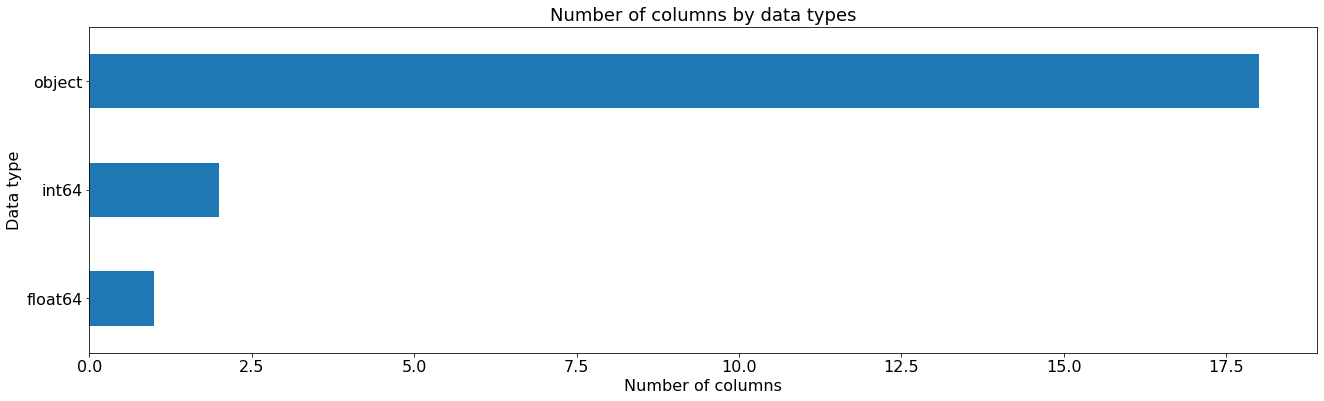

In [5]:
df.dtypes.value_counts().sort_values().plot(kind='barh',
                                            figsize=(22, 6),
                                            fontsize=16)

plt.title('Number of columns by data types', fontsize=18)
plt.xlabel('Number of columns', fontsize=16)
plt.ylabel('Data type', fontsize=16)


####A lot of Categorical variables, let's look how many outcomes are possible for each categorical variable


In [6]:
nunique_df = pd.DataFrame(df.select_dtypes('object').apply(pd.Series.nunique, axis=0), columns=['Variants'])
nunique_df


,Variants
customerID,7043
gender,2
Partner,2
Dependents,2
PhoneService,2
MultipleLines,3
InternetService,3
OnlineSecurity,3
OnlineBackup,3
DeviceProtection,3


The data type for TotalCharges is Object, this should be typecasted to float. The missing values are replaced by 0

In [7]:
for i in range(len(df)):
    if df.TotalCharges.iloc[i] != ' ':
         df.TotalCharges.iloc[i] = float(df.TotalCharges.iloc[i])
    else:
        df.TotalCharges.iloc[i] = 0

df = df.astype({'TotalCharges': 'float'})

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [8]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


Checking for missing values in columns other than TotalCharges since that column is already dealt with

In [9]:

def missing_values(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns={
        0: 'Missing Values',
        1: '% of Total Values'
    })
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
            '% of Total Values', ascending=False).round(1)
    print("Dataframe has " + str(df.shape[1]) + " columns.")
    print("There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")
    
    return mis_val_table_ren_columns

# Missing values statistics
miss_values = missing_values(df)
miss_values.head(20)


Dataframe has 21 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


Creating a target variable

In [10]:
df['Churn'].unique()

target = [ 1 if i == 'Yes' else 0 for i in df['Churn']]

df['target'] = target
df['target'].value_counts()

0    5174
1    1869
Name: target, dtype: int64

We notice that 0 is much more common of an outcome than 1

In [0]:
df.drop('Churn', axis=1, inplace=True)


Checking correlation between numerical variables

In [12]:

corr = df.corr()['target'].sort_values()

# Display correlations
print('Top 5 - Positive Correlations:')
print('-----------------------------------')
print(corr.tail(5))
print('\nTop 5 - Negative Correlations:')
print('------------------------------')
print(corr.head(5))


Top 5 - Positive Correlations:
-----------------------------------
tenure           -0.352229
TotalCharges     -0.198324
SeniorCitizen     0.150889
MonthlyCharges    0.193356
target            1.000000
Name: target, dtype: float64

Top 5 - Negative Correlations:
------------------------------
tenure           -0.352229
TotalCharges     -0.198324
SeniorCitizen     0.150889
MonthlyCharges    0.193356
target            1.000000
Name: target, dtype: float64


####Visualising the Correaltion

[Text(0.5, 0, 'SeniorCitizen'),
 Text(1.5, 0, 'tenure'),
 Text(2.5, 0, 'MonthlyCharges'),
 Text(3.5, 0, 'TotalCharges'),
 Text(4.5, 0, 'target')]

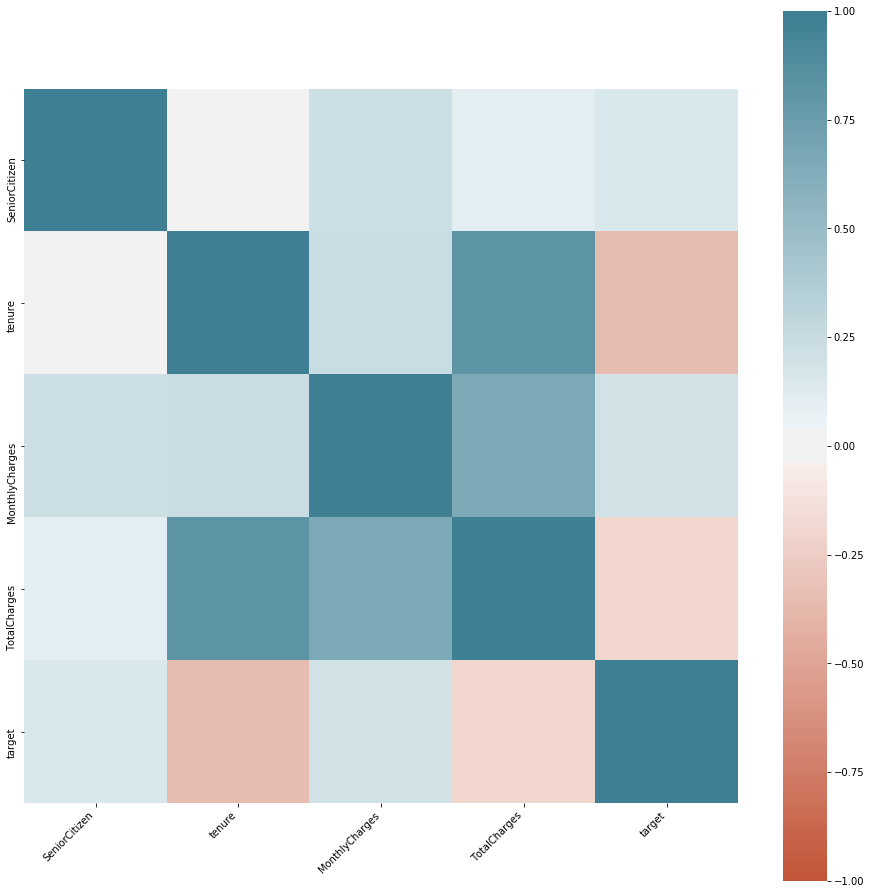

In [13]:

correlation = df.corr()
plt.figure(figsize=(16, 16))
ax = sns.heatmap(
    correlation, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

 

Dropping ID column

In [0]:

df.drop(['customerID'],
        axis=1,
        inplace=True)


In [15]:
df.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


Dummifying categorical variables

#### Encoding and Dummifying

In [0]:

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [18]:
binary = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
df = MultiColumnLabelEncoder(columns = binary).fit_transform(df)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
0,0,0,1,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,1,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50,0
2,1,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1
3,1,0,0,0,45,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,0,0,0,0,2,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1


In [0]:
categorical = ['MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaymentMethod']
df = pd.get_dummies(df, columns = categorical)


In [21]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,target,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0


Making feature vectors and target variable

In [0]:
y = df.target
X = df.drop(['target'], axis = 1)

In [23]:
X.shape

(7043, 40)

In [0]:
df.to_csv('no_removal_preprocessed_data.csv')

##  Trying different models


In [0]:
results = {
    'Model':[], 
    'Accuracy':[], 
    'F1 Score':[]
    }

####  1. K-NN 


In [27]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler()

X_std = standardizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size = 0.33, random_state = 7)

knn = KNeighborsClassifier(n_neighbors = 7)
model = knn.fit(X_train, y_train)


y_test_pred = knn.predict(X_test)

from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_test_pred)
print(acc, f1_score(y_test, y_test_pred))

results['Model'].append('KNN')
results['Accuracy'].append(acc)
results['F1 Score'].append(f1_score(y_test, y_test_pred))

0.7729032258064517 0.5643564356435644


#### 2. Decision Tree 


In [28]:
from sklearn.tree import DecisionTreeClassifier
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size = 0.33, random_state = 5)

dtree = DecisionTreeClassifier(max_depth = 5)
model = dtree.fit(X_train, y_train)

y_test_pred = dtree.predict(X_test)

from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_test_pred)

print(acc, f1_score(y_test, y_test_pred))

results['Model'].append('DecisionTree')
results['Accuracy'].append(acc)
results['F1 Score'].append(f1_score(y_test, y_test_pred))

0.7926881720430108 0.5418250950570342


####  3. Random Forest 


In [29]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 5)

rf = RandomForestClassifier(random_state = 0, n_estimators = 1000)
model = rf.fit(X_train, y_train)

y_test_pred = rf.predict(X_test)

from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_test_pred)

print(acc, f1_score(y_test, y_test_pred))

results['Model'].append('Random Forest')
results['Accuracy'].append(acc)
results['F1 Score'].append(f1_score(y_test, y_test_pred))

0.7926881720430108 0.5602189781021898


In [30]:
results

{'Accuracy': [0.7729032258064517, 0.7926881720430108, 0.7926881720430108],
 'F1 Score': [0.5643564356435644, 0.5418250950570342, 0.5602189781021898],
 'Model': ['KNN', 'DecisionTree', 'Random Forest']}

In [0]:

 from sklearn.model_selection import GridSearchCV
 import numpy as np
 
 

base_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
base_model.fit(X_train, y_train)
base_acc = accuracy_score(y_test, base_model.predict(X_test))

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 500, 700, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
grid_search.fit(X, y)
grid_search.best_params_

best_grid = grid_search.best_estimator_
grid_acc = accuracy_score(y_test, best_grid.predict(X_test))
 
print('Improvement of {:0.2f}%.'.format( 100 * (grid_acc - base_acc) / base_acc))


print(grid_acc, f1_score(y_test, y_test_pred))

results['Model'].append('Tuned Random Forest')
results['Accuracy'].append(grid_acc)
results['F1 Score'].append(f1_score(y_test,best_grid.predict(X_test)))

Fitting 3 folds for each of 2160 candidates, totalling 6480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 42.0min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 73.3min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed: 87.1min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 116.2min
[Parallel(n_jobs=-1)]: Done 3277 tasks      | elapsed: 154.6min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 183.7min
[Parallel(n_jobs=-1)]: Done 4897 tasks      | elapsed: 231.4min
[Parallel(n_jobs=-1)]: Done 5828 tasks      | elapsed: 269.8min


#### 4. Logistic Regression


In [31]:
from sklearn.linear_model import LogisticRegression
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = 5)

lm3 = LogisticRegression()
model3 = lm3.fit(X_train, y_train)

y_test_pred = lm3.predict(X_test)

acc = accuracy_score(y_test,y_test_pred)

print(acc, f1_score(y_test, y_test_pred))

results['Model'].append('Logistic Regression')
results['Accuracy'].append(acc)
results['F1 Score'].append(f1_score(y_test, y_test_pred))

0.8008602150537635 0.59135039717564


#### 5. XG Boost Classifier


#### Grid Search CV to tune Random Forest Classifier

In [32]:
import xgboost as xgb

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = 5)

xgc = xgb.XGBClassifier()

xgc.fit(X_train,y_train)

preds = xgc.predict(X_test)

acc = (accuracy_score(y_test, preds))

print(acc, f1_score(y_test, preds))

results['Model'].append('XG Boost')
results['Accuracy'].append(acc)
results['F1 Score'].append(f1_score(y_test, preds))

0.807741935483871 0.5880184331797236


####Results

In [0]:
results_df = pd.DataFrame(results)
results_df.to_csv('results without dropping any predictor.csv')

# New Section